# MNIST Classification


In [1]:
# import stuff
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd

In [2]:
# fetch data from mnist database
mnist = fetch_openml('mnist_784', version = 1, parser='liac-arff')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print('features: ', X.shape, ' labels: ', y.shape)

features:  (70000, 784)  labels:  (70000,)


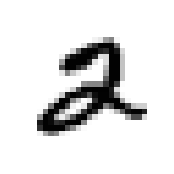

In [4]:
# let's visualize one of the characters
import matplotlib as mpl
import matplotlib.pyplot as plt

# the 784 features represent pixel intensity of a 28 x 28 image
image_index = 5
some_digit = np.array(X.iloc[image_index])
some_digit_image = some_digit.reshape(28,28) # resizes vector to 2D array
plt.figure(figsize=(2, 2))
plt.imshow(some_digit_image, cmap = 'binary')
plt.axis('off')
plt.show()


In [5]:
print('the above should looks like a ', y[image_index])

the above should looks like a  2


In [6]:
# typically, we want labels to be numbers, so let's cast to an integer
y = y.astype(np.uint8)
type(y[image_index])

numpy.uint8

In [7]:
# let's create a training and test set
train_test_split = 60000
X_train, X_test, y_train, y_test = X.iloc[:train_test_split], X.iloc[train_test_split:], y[:train_test_split], y[train_test_split:]

In [8]:
# build a binary classifier (in this case, a 5 detector)
y_train_5 = (y_train == 5) # returns a Boolean array same size as y_train (if 5 True, else False)
y_test_5 = (y_test == 5)

In [9]:
# create a binary classifier (Stochastic Gradient Descent)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
image_index = 0
some_digit = X.iloc[image_index]
sgd_clf.predict([some_digit])

/Users/tjards/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [11]:
# let's use cross validation to measure accuracy 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
# let's build a dumb classifier that pumps out not-5
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv =3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

In [13]:
# this just suggests roughly 10 percent of the set is 5's, rather than speak to the model's accuracy
print('training set contains' , 100*(np.sum(y_train_5 == 1)/len(y_train_5)), '% percent True 5 samples')

training set contains 9.035 % percent True 5 samples


In [14]:
# build the confusion matrix, which is a better indicator
from sklearn.model_selection import cross_val_predict 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

#          Predicted
#          __0___1__
#Actual  0| TN | FP |
#        1| FN | TP |
#          ---------


array([[53892,   687],
       [ 1891,  3530]])

In [16]:
# compute precisions and recall
from sklearn.metrics import precision_score, recall_score
print('precision: ', precision_score(y_train_5, y_train_pred))
print('recall: ', recall_score(y_train_5, y_train_pred))

precision:  0.8370879772350012
recall:  0.6511713705958311


In [17]:
# compute F1-score, which is a composite of these two
from sklearn.metrics import f1_score
print('F1 score: ', f1_score(y_train_5, y_train_pred))

F1 score:  0.7325171197343846


In [20]:
# precision/recall trade-off depends on decision function threshold
y_scores = sgd_clf.decision_function([some_digit])
print('score for digit ', image_index, ': ', y_scores)

score for digit  0 :  [2164.22030239]


/Users/tjards/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [21]:
# manually check if score is above user-defined threshold
threshold = 0 
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [22]:
# raise the threshold (more precision, less recall)
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)


[False]


In [29]:
# return decisions scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = 'decision_function')

In [30]:
# compute precision/recall for all possible thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

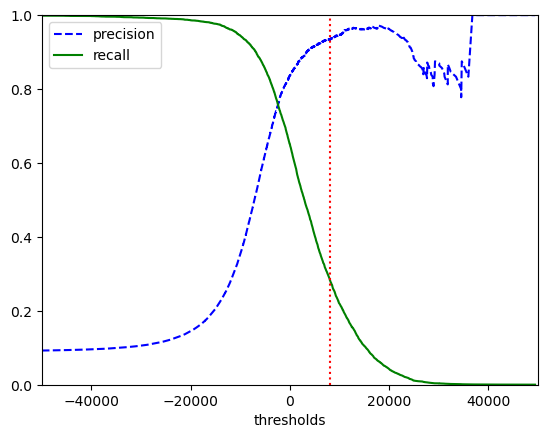

In [45]:
# now plot them 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'recall')
    plt.axis([-50000, 50000, 0, 1])
    plt.axvline(threshold, color = 'r', linestyle = ':')
    plt.xlabel('thresholds')
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

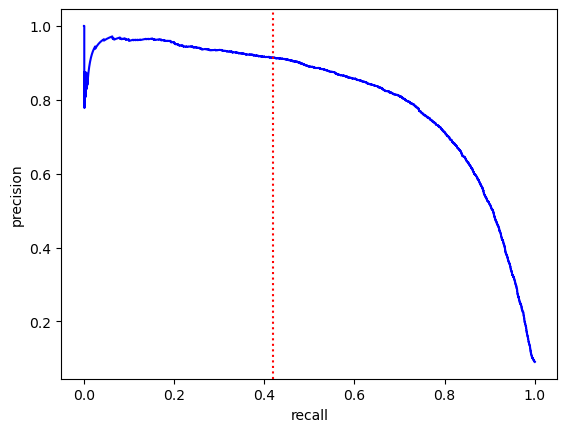

In [50]:
# try just precision vs recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], 'b-')
    #plt.axis([-50000, 50000, 0, 1])
    plt.axvline(0.42, color = 'r', linestyle = ':')
    plt.xlabel('recall')
    plt.ylabel('precision')
    #plt.legend()
plot_precision_vs_recall(precisions, recalls)
plt.show()    


In [52]:
# find lowest threshold to get 90% precision
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]
print(threshold_90_precision)

3370.019499143958


In [56]:
y_train_pred_90  = (y_scores >= threshold_90_precision)
print('precision: ', precision_score(y_train_5, y_train_pred_90))
print('recall: ', recall_score(y_train_5, y_train_pred_90))

precision:  0.9000345901072293
recall:  0.4799852425751706
